In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.mas.rows=5)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
url<-"https://raw.githubusercontent.com/Muskandavee/PROPOSAL-/main/heart.csv?token=GHSAT0AAAAAACIL7C5ONUF7EQO6NRJV2VSKZJ4MAEQ"

In [13]:
download.file(url, "data/heart.csv")
heart_disease_data<-read_csv("data/heart.csv")|>
mutate(HeartDisease=as_factor(HeartDisease))|>
rename(ST_depression=Oldpeak)|>
mutate(HeartDisease=ifelse(HeartDisease==1, "Yes", "No"))|>
select(Age:HeartDisease)

heart_disease_slice<-heart_disease_data|>
slice(1:5)
heart_disease_slice

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
40,M,ATA,140,289,0,Normal,172,N,0.0,Up,No
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,Yes
37,M,ATA,130,283,0,ST,98,N,0.0,Up,No
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,Yes
54,M,NAP,150,195,0,Normal,122,N,0.0,Up,No


In [14]:
set.seed(1234)
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = HeartDisease)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

heart_disease_slice_train<-heart_disease_train |>
slice(1:5)
heart_disease_slice_train

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
37,M,ATA,130,283,0,ST,98,N,0,Up,No
39,M,NAP,120,339,0,Normal,170,N,0,Up,No
54,M,ATA,110,208,0,Normal,142,N,0,Up,No
48,F,ATA,120,284,0,Normal,120,N,0,Up,No
42,F,NAP,115,211,0,ST,137,N,0,Up,No


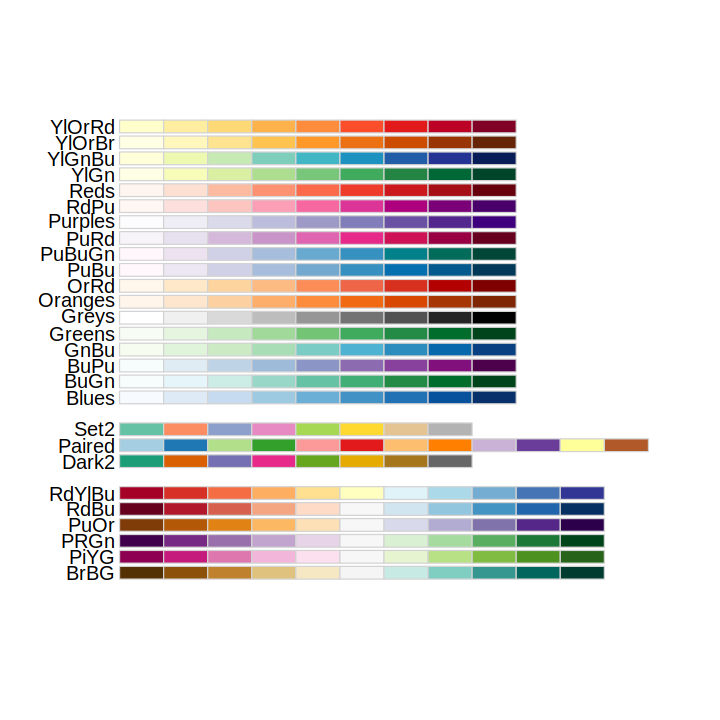

In [15]:
display.brewer.all(colorblindFriendly = TRUE)

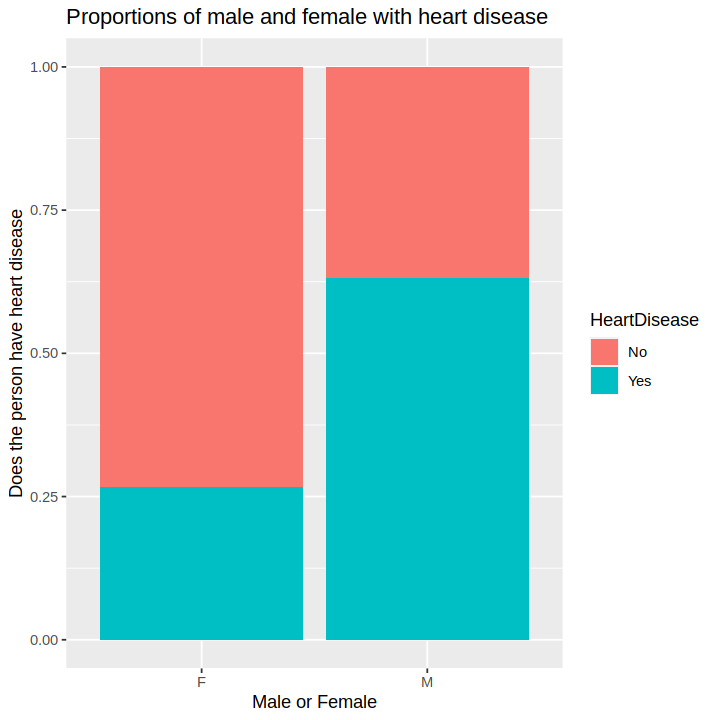

In [16]:
options(repr.plot.width = 6, repr.plot.height = 6)
sex_plot<-heart_disease_train|>
ggplot(aes(x=Sex, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("Male or Female")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of male and female with heart disease")+
scale_color_brewer(palette = "Set2")
sex_plot

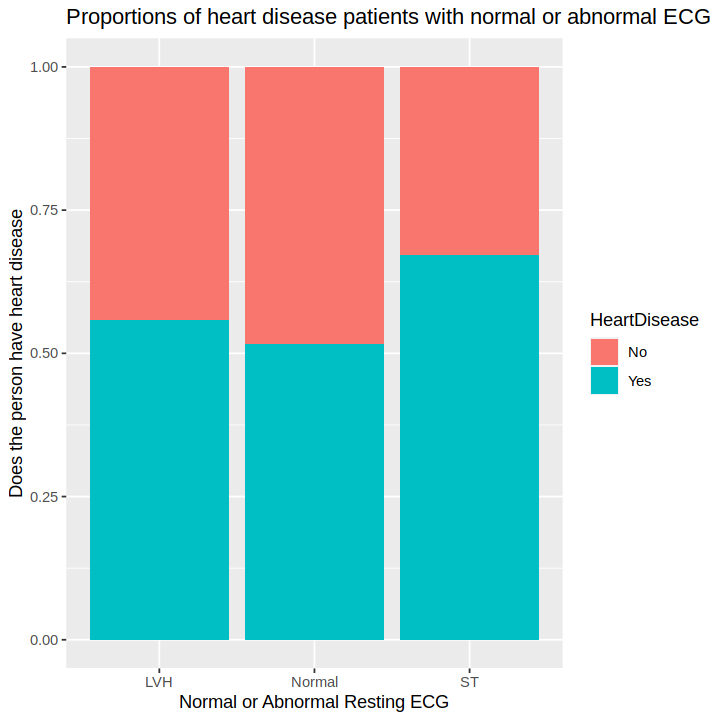

In [17]:
options(repr.plot.width = 6, repr.plot.height = 6)
Resting_ECG_plot<-heart_disease_train|>
ggplot(aes(x=RestingECG, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("Normal or Abnormal Resting ECG")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of heart disease patients with normal or abnormal ECG")
Resting_ECG_plot

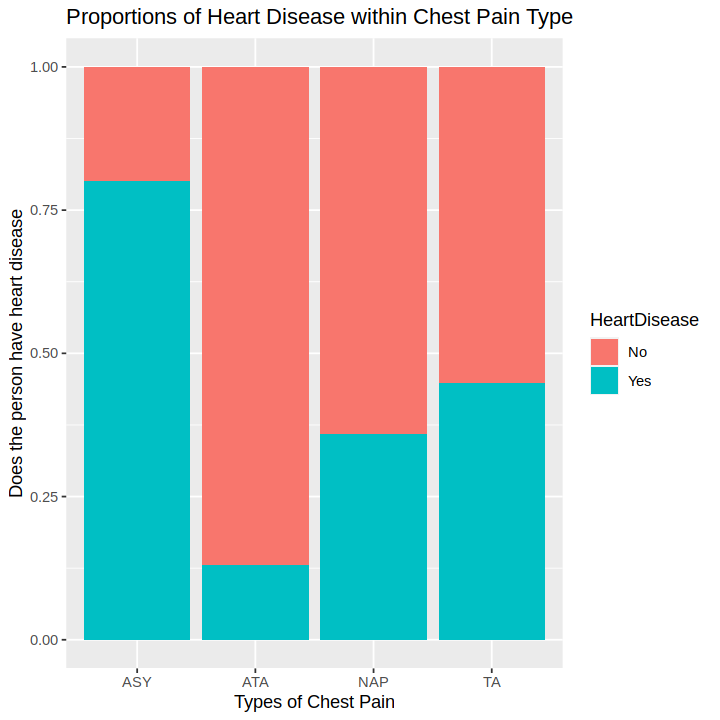

In [18]:
options(repr.plot.width = 6, repr.plot.height = 6)
Chest_pain_type_plot<-heart_disease_train|>
ggplot(aes(x=ChestPainType, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("Types of Chest Pain")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of Heart Disease within Chest Pain Type")
Chest_pain_type_plot

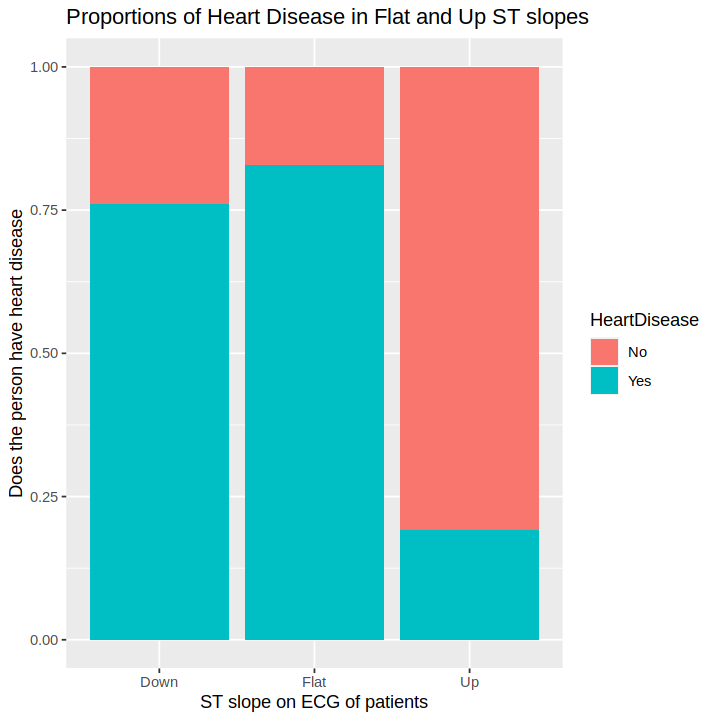

In [19]:
options(repr.plot.width = 6, repr.plot.height = 6)
ST_Slope_plot<-heart_disease_train|>
ggplot(aes(x=ST_Slope, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("ST slope on ECG of patients")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of Heart Disease in Flat and Up ST slopes")
ST_Slope_plot

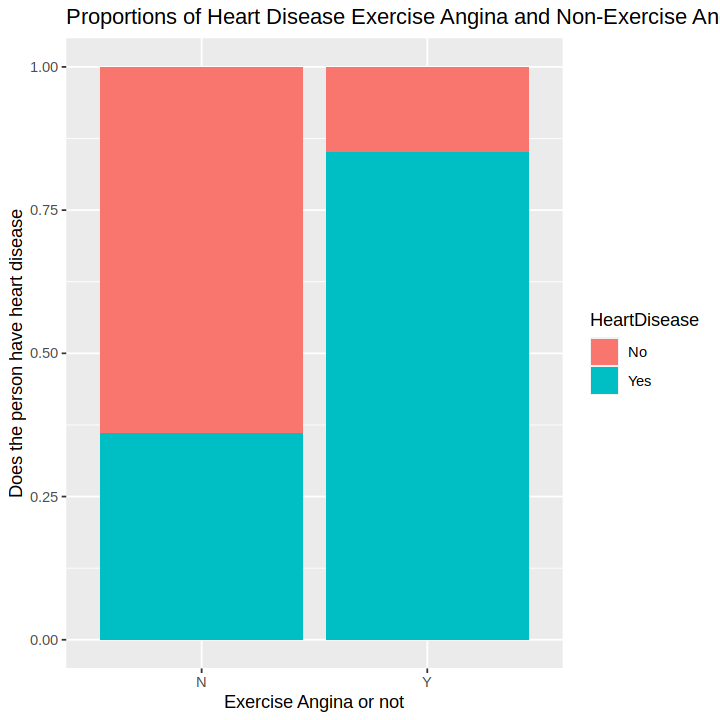

In [20]:
options(repr.plot.width = 6, repr.plot.height = 6)
Exercise_Angina_plot<-heart_disease_train|>
ggplot(aes(x=ExerciseAngina, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("Exercise Angina or not")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of Heart Disease Exercise Angina and Non-Exercise Angina")
Exercise_Angina_plot